In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.linear_model import LogisticRegression

In [13]:
titanic = pd.read_csv('titanic.csv')

In [14]:
titanic.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


# Exploratory data analysis 

### Check for missing values 

In [15]:
# Check for missing values
titanic.isnull().sum()

# Filter out columns that have zero missing values per titanic.isnull().sum()
titanic.isnull().sum()[titanic.isnull().sum() != 0].sort_values(ascending=False)

Cabin       687
Age         177
Embarked      2
dtype: int64

### Replace missing age values with the mean age by Sex and Pclass

In [16]:
subgroups = titanic.groupby(["Sex", 'Pclass']).mean()
subgroups["Age"]

Sex     Pclass
female  1         34.611765
        2         28.722973
        3         21.750000
male    1         41.281386
        2         30.740707
        3         26.507589
Name: Age, dtype: float64

In [17]:
titanic['Age'] = titanic.groupby(["Sex", 'Pclass'])["Age"]\
.transform(lambda x: x.fillna(x.mean()))

In [18]:
# Check for missing values
titanic.isnull().sum()

# Filter out columns that have zero missing values per titanic.isnull().sum()
titanic.isnull().sum()[titanic.isnull().sum() != 0].sort_values(ascending=False)

Cabin       687
Embarked      2
dtype: int64

In [19]:
titanic.dropna(subset=['Embarked'], inplace=True, axis=0)
titanic.isnull().sum()[titanic.isnull().sum() != 0].sort_values(ascending=False)

Cabin    687
dtype: int64

In [20]:
titanic = pd.concat([titanic, pd.get_dummies(titanic["Embarked"], 
                                             prefix = 'Embarked_', 
                                             drop_first=True)],axis = 1)

In [21]:
print(titanic.filter(regex='Embarked').columns)
titanic.filter(regex='Embarked').head()

Index(['Embarked', 'Embarked__Q', 'Embarked__S'], dtype='object')


,Embarked,Embarked__Q,Embarked__S
0,S,0,1
1,C,0,0
2,S,0,1
3,S,0,1
4,S,0,1


In [22]:
titanic.drop(['Embarked'], axis=1, inplace=True)

In [23]:
titanic.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked__Q      uint8
Embarked__S      uint8
dtype: object

### Check the distributions of your features

In [24]:
titanic.describe().T.style

,count,mean,std,min,25%,50%,75%,max
PassengerId,889,446,256.998,1,224,446,668,891
Survived,889,0.382452,0.48626,0,0,0,1,1
Pclass,889,2.31159,0.8347,1,2,3,3,3
Age,889,29.2721,13.2475,0.42,21.75,26.5076,36,80
SibSp,889,0.524184,1.1037,0,0,0,1,8
Parch,889,0.382452,0.806761,0,0,0,0,6
Fare,889,32.0967,49.6975,0,7.8958,14.4542,31,512.329
Embarked__Q,889,0.0866142,0.281427,0,0,0,0,1
Embarked__S,889,0.724409,0.447063,0,0,1,1,1


### How many people survived? 

In [25]:
titanic["Survived"].value_counts()

0    549
1    340
Name: Survived, dtype: int64

### Explore your other features

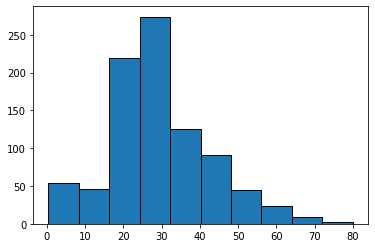

In [26]:
titanic['Age'].hist(grid=False, edgecolor='#000000');

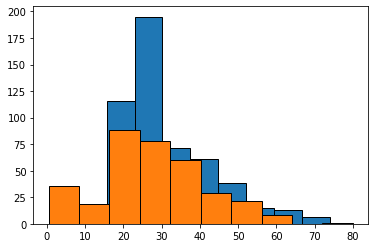

In [27]:
titanic.groupby('Survived').Age.hist(grid=False, edgecolor='#000000');

In [28]:
titanic['Pclass'].value_counts().sort_index()

1    214
2    184
3    491
Name: Pclass, dtype: int64

In [29]:
# sibsp - Number of Siblings/Spouses Aboard
titanic["SibSp"].value_counts().sort_index()

0    606
1    209
2     28
3     16
4     18
5      5
8      7
Name: SibSp, dtype: int64

In [30]:
# parch - Number of Parents/Children Aboard
titanic["Parch"].value_counts().sort_index()

0    676
1    118
2     80
3      5
4      4
5      5
6      1
Name: Parch, dtype: int64

### How would you clean/combine these features?

Given the sample sizes, most people had neither a parent nor a sibling on board thus I'll just create indicator variables `had_parent` and  `had_sib`

In [31]:
titanic['had_parents'] = titanic.Parch.apply(lambda x: 1 if x > 0 else 0)
titanic['had_parents'].value_counts()

0    676
1    213
Name: had_parents, dtype: int64

In [32]:
titanic['had_siblings'] = titanic.SibSp.apply(lambda x: 1 if x > 0 else 0)
titanic['had_siblings'].value_counts()

0    606
1    283
Name: had_siblings, dtype: int64

### Which additional features require dummy variables? Create dummies for each of your categorical features

In [33]:
# Dummying up the hard way using .apply() and a lambda function
titanic['is_female'] = titanic.Sex.apply(lambda x: 1 if x == 'female' else 0)

In [34]:
titanic["Sex"].value_counts()

male      577
female    312
Name: Sex, dtype: int64

In [35]:
titanic["is_female"].value_counts()

0    577
1    312
Name: is_female, dtype: int64

In [36]:
titanic.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked__Q', 'Embarked__S',
       'had_parents', 'had_siblings', 'is_female'],
      dtype='object')

In [37]:
titanic.corr().style

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,Embarked__Q,Embarked__S,had_parents,had_siblings,is_female
PassengerId,1,-0.00502832,-0.0353298,0.0368326,-0.0576859,-0.00165658,0.0127032,-0.0336937,0.0222688,0.00518135,-0.0535588,-0.043136
Survived,-0.00502832,1,-0.335549,-0.0723206,-0.03404,0.0831508,0.25529,0.00453573,-0.151777,0.149328,0.118087,0.541585
Pclass,-0.0353298,-0.335549,1,-0.404114,0.0816556,0.0168245,-0.548193,0.220558,0.0764664,-0.0295931,-0.0786712,-0.127741
Age,0.0368326,-0.0723206,-0.404114,1,-0.250629,-0.179747,0.115477,-0.0833043,0.0144454,-0.260522,-0.153026,-0.118279
SibSp,-0.0576859,-0.03404,0.0816556,-0.250629,1,0.414542,0.160887,-0.0266917,0.0694383,0.461923,0.695374,0.116348
Parch,-0.00165658,0.0831508,0.0168245,-0.179747,0.414542,1,0.217532,-0.0815851,0.0615116,0.845007,0.355682,0.247508
Fare,0.0127032,0.25529,-0.548193,0.115477,0.160887,0.217532,1,-0.116684,-0.163758,0.239264,0.19397,0.179958
Embarked__Q,-0.0336937,0.00453573,0.220558,-0.0833043,-0.0266917,-0.0815851,-0.116684,1,-0.499261,-0.0978999,-0.055905,0.0752167
Embarked__S,0.0222688,-0.151777,0.0764664,0.0144454,0.0694383,0.0615116,-0.163758,-0.499261,1,0.0336239,0.00536183,-0.121405
had_parents,0.00518135,0.149328,-0.0295931,-0.260522,0.461923,0.845007,0.239264,-0.0978999,0.0336239,1,0.419741,0.249837


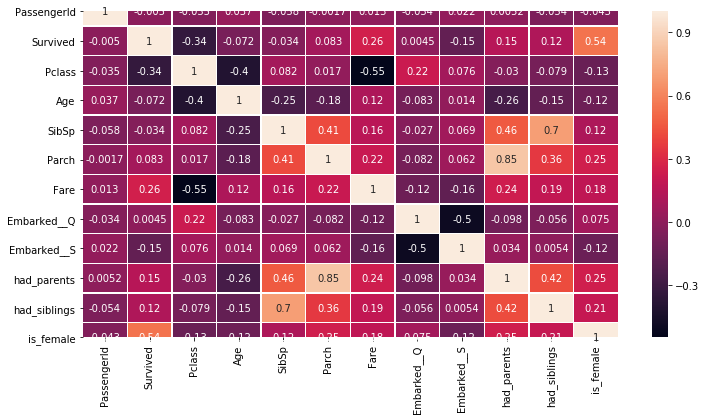

In [38]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(12,6))
sns.heatmap(titanic.corr(), annot=True, linewidth=0.4);

## Using scikit for prediction

In [39]:
titanic.dtypes

PassengerId       int64
Survived          int64
Pclass            int64
Name             object
Sex              object
Age             float64
SibSp             int64
Parch             int64
Ticket           object
Fare            float64
Cabin            object
Embarked__Q       uint8
Embarked__S       uint8
had_parents       int64
had_siblings      int64
is_female         int64
dtype: object

In [40]:
titanic.Survived.value_counts()

0    549
1    340
Name: Survived, dtype: int64

In [41]:
# Fit a logistic regression model and store the class predictions.
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression()

feature_cols = ['is_female']
#feature_cols = ['is_female', 'Embarked__Q', 'Embarked__S', 'Pclass', 'Age']
X = titanic[feature_cols]
y = titanic.Survived

logreg.fit(X,y)
y_preds = logreg.predict(X)

In [42]:
unique, counts = np.unique(y_preds, return_counts=True)
print(np.asarray((unique, counts)))

[[  0   1]
 [577 312]]


In [43]:
print(len(y_preds[y_preds==0]))
print(len(y_preds[y_preds==1]))

577
312


In [44]:
from sklearn.metrics import accuracy_score
accuracy_score(y, y_preds)

0.7862767154105736

In [45]:
# baseline
titanic.Survived.value_counts(normalize=True)[0]

0.6175478065241845

In [46]:
titanic['survived_pred'] = logreg.predict(X)

In [47]:
titanic[['Survived', 'survived_pred']].head()

,Survived,survived_pred
0,0,0
1,1,1
2,1,1
3,1,1
4,0,0


What if we wanted the predicted probabilities instead of just the class predictions, to understand how confident we are in a given prediction?

**Using the built-in `.predict_proba()` function, examine the predicted probabilities for the first handful of rows.**

In [48]:
logreg.predict_proba(X)[0:10]

array([[0.80686733, 0.19313267],
       [0.26742775, 0.73257225],
       [0.26742775, 0.73257225],
       [0.26742775, 0.73257225],
       [0.80686733, 0.19313267],
       [0.80686733, 0.19313267],
       [0.80686733, 0.19313267],
       [0.80686733, 0.19313267],
       [0.26742775, 0.73257225],
       [0.26742775, 0.73257225]])

Sklearn orders the columns according to our class labels. The two-column output of `predict_proba` returns a column for each class of our `Survived` variable. 

**The first column is the probability of `Survived=0` for a given row, and the second column is the probability of `Survived=1`.**

**Store the predicted probabilities of `Survived=1` in its own column in the data set.**

In [49]:
titanic['survived_pred_prob'] = logreg.predict_proba(X)[:, 1]
titanic['deceased_pred_prob'] = logreg.predict_proba(X)[:, 0]

In [50]:
titanic[['Survived', 'survived_pred', 
         'deceased_pred_prob', 'survived_pred_prob']].head(10)

,Survived,survived_pred,deceased_pred_prob,survived_pred_prob
0,0,0,0.806867,0.193133
1,1,1,0.267428,0.732572
2,1,1,0.267428,0.732572
3,1,1,0.267428,0.732572
4,0,0,0.806867,0.193133
5,0,0,0.806867,0.193133
6,0,0,0.806867,0.193133
7,0,0,0.806867,0.193133
8,1,1,0.267428,0.732572
9,1,1,0.267428,0.732572
